# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: José Ángel León Pérez

**Professor**: Pablo Camarillo Ramirez

# Introduction

Ticketmaster faces extreme traffic spikes during presales, when millions of users simultaneously try to access the platform to search for tickets, add them to their carts, and complete purchases. This massive surge in activity generates an enormous amount of data, including user interactions, queue events, and payment transactions — that must be processed efficiently to maintain fairness and ensure a smooth user experience.

While the original data pipeline design focused on real-time stream processing to handle events as they occurred, this project adapts the architecture for batch processing using Apache Spark. The pipeline aims to process large volumes of historical transaction logs and queueing data collected after presale events, consolidating them into aggregated summaries that describe platform performance and user behavior during those high-demand periods.

By adopting a batch-oriented strategy, the system performs offline analysis to generate insights such as conversion rates, average waiting times, sales per event, and payment success ratios. Once the data is transformed and summarized, the results are persisted into a PostgreSQL relational database, enabling structured storage, optimized querying, and seamless integration with reporting or business intelligence tools.

# Dataset

For this project, the dataset is synthetically generated using the Faker library in order to simulate the type of raw data that Ticketmaster could produce during massive presale events. The generated dataset intentionally contains incomplete, duplicated, and inconsistent records to represent realistic data quality issues that occur in large-scale transactional systems such as missing user names, duplicated transactions, or incorrect totals.

These simulated irregularities allow the batch pipeline to demonstrate a complete ETL process (which I learned at my Data Warehouse class), in which Apache Spark is used to clean, validate, and aggregate the data before persisting the final results. Through this process, the pipeline will extract valuable insights and performance metrics for each event, such as total tickets sold, total revenue, failed payments, and conversion rates.

### Raw Dataset Schema

The raw dataset includes attributes such as:

- user — the username or identifier of the buyer (sometimes missing).  
- event_id and event_name — identifiers for each concert or show.  
- ticket_count and price_per_ticket — individual purchase details.  
- total — the computed or sometimes inconsistent purchase total.  
- payment_status — the transaction outcome (completed, failed, or pending).  
- queue_position, wait_time, and timestamp — queue and timing information for each presale interaction.  

### Processed Dataset Schema

After the Spark transformation phase, the data should look something like this:

- event_id and event_name — unique identifiers for each event.  
- total_tickets_sold — total number of tickets sold successfully.  
- total_revenue — total sum of completed payments.  
- failed_payments — number of failed transactions per event.  
- avg_wait_time — average waiting time in queue for all users of the event.  
- conversion_rate — ratio of successful purchases over total purchase attempts.  
- processing_date — date when the batch process was executed.  



In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Ticketmaster - Final Proyect") \
    .master("spark://f96d92aa7215:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/27 18:09:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [20]:
from jos.spark_utils import SparkUtils  

columns_info = [
    ("user", "string"),
    ("event_id", "string"),
    ("event_name", "string"),
    ("ticket_count", "int"),
    ("price_per_ticket", "double"),
    ("total", "double"),
    ("payment_status", "string"),
    ("queue_position", "int"),
    ("wait_time", "double"),
    ("timestamp", "timestamp")
]

schema = SparkUtils.generate_schema(columns_info)

df_raw = spark.read.csv(
    "../../data/dirty_ticketmaster_data.csv",
    header=True,
    schema=schema
)

print("Dirty dataset loaded successfully into Spark!")


Dirty dataset loaded successfully into Spark!


# Transformations and Actions

Before loading the data into the final storage, we perform a full cleaning and transformation phase.
The raw data created with Faker simulates real-world issues such as:

- Missing values in the user and payment_status columns.

- Duplicated transactions.

- Incorrect or inconsistent totals (for example, the total value not matching the product of tickets × price).

- Invalid ticket counts or prices (zero or negative).

The goal of this phase is to prepare the data for aggregation and analysis by fixing these issues and computing new metrics that reflect accurate performance for each event.

In [23]:
from pyspark.sql import functions as F

print("Initial count:", df_raw.count())

df_clean = df_raw.dropna(subset=["user", "payment_status", "event_id"])
print("After dropping nulls:", df_clean.count())

df_clean = df_clean.dropDuplicates()
print("After removing duplicates:", df_clean.count())

df_clean = df_clean.withColumn(
    "total_corrected",
    F.when(
        F.abs(F.col("total") - (F.col("ticket_count") * F.col("price_per_ticket"))) > 1,
        F.col("ticket_count") * F.col("price_per_ticket")
    ).otherwise(F.col("total"))
)

df_clean = df_clean.filter((F.col("ticket_count") > 0) & (F.col("price_per_ticket") > 0))
print("After filtering invalid values:", df_clean.count())

df_clean = df_clean.withColumn(
    "is_successful",
    F.when(F.col("payment_status") == "completed", 1).otherwise(0)
)


df_processed = df_clean.groupBy("event_id", "event_name").agg(
    F.sum(F.when(F.col("payment_status") == "completed", F.col("ticket_count")).otherwise(0)).alias("total_tickets_sold"),
    F.sum(F.when(F.col("payment_status") == "completed", F.col("total_corrected")).otherwise(0)).alias("total_revenue"),
    F.count(F.when(F.col("payment_status") == "failed", True)).alias("failed_payments"),
    F.avg("wait_time").alias("avg_wait_time"),
    (F.sum(F.when(F.col("payment_status") == "completed", 1).otherwise(0)) / F.count("*")).alias("conversion_rate")
).withColumn("processing_date", F.current_date())



Initial count: 202
After dropping nulls: 188
After removing duplicates: 186
After filtering invalid values: 186


# Persistence Data

For the persistence layer, PostgreSQL was selected because it provides strong support for relational and analytical workloads, which aligns perfectly with the structure of the processed dataset. Since the pipeline produces aggregated event-level metrics (such as total revenue and conversion rates), a relational database ensures data integrity, efficient SQL querying, and compatibility with BI tools.

In [24]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "ticketmaster_processed"

df_processed.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Processed Ticketmaster dataset successfully written into PostgreSQL DB!")

db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

df_postgres = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

df_postgres.printSchema()
df_postgres.show(10, truncate=False)


[Stage 168:>                                                        (0 + 1) / 1]

Processed Ticketmaster dataset successfully written into PostgreSQL DB!
root
 |-- event_id: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- total_tickets_sold: long (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- failed_payments: long (nullable = true)
 |-- avg_wait_time: double (nullable = true)
 |-- conversion_rate: double (nullable = true)
 |-- processing_date: date (nullable = true)

+-----------+--------------------------------------+------------------+-------------+---------------+-------------+---------------+---------------+
|event_id   |event_name                            |total_tickets_sold|total_revenue|failed_payments|avg_wait_time|conversion_rate|processing_date|
+-----------+--------------------------------------+------------------+-------------+---------------+-------------+---------------+---------------+
|EV-MOD-4803|Modern Baseball Live in South Jennifer|5                 |7728.7       |0              |232.16       |1.0   

# DAG VISUALIZATION

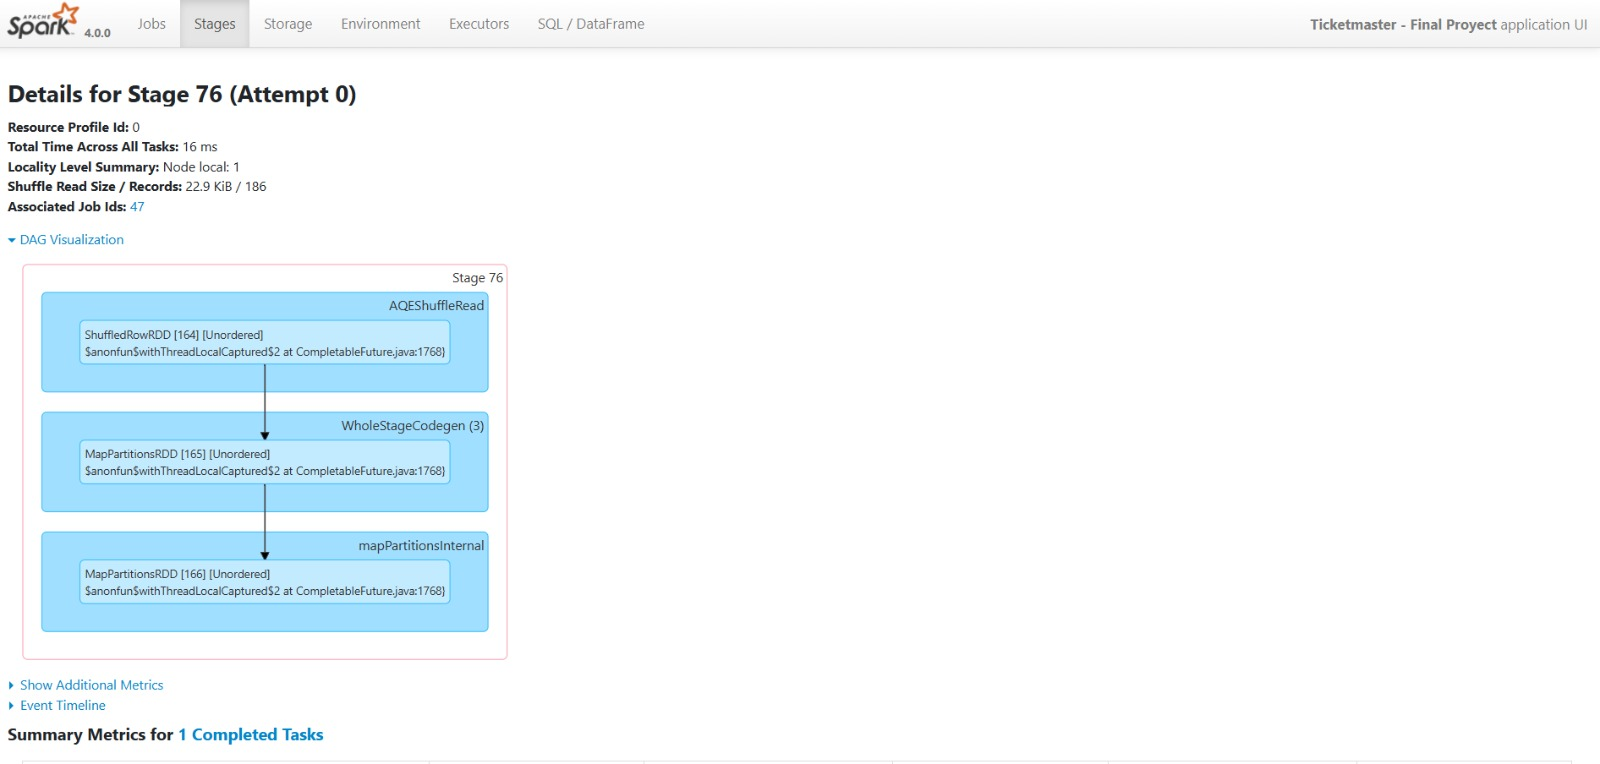

In [25]:
sc.stop()